Filter, Extract, Transform Polygon Shapes into GeoJson Standard - Input: Place Name (Kassel / Germany, etc.) - Output: GeoJson FeatureCollection

In [7]:
import osmnx as ox
import geopandas as gpd
import json
from shapely.geometry import MultiPolygon, Polygon

# Set the default CRS to EPSG:25832 for consistent spatial reference
ox.settings.default_crs = "epsg:25832"

# Initialize a GeoDataFrame ('gdf') and a list ('mongo_data_list') for data storage
gdf = gpd.GeoDataFrame()
mongo_data_list = []

def create_postal_code_gdf(place_name, tags):
    global gdf, mongo_data_list  # Utilize global GeoDataFrame and list

    # Fetch place polygons using OpenStreetMap data
    place_polygons = ox.features_from_place(place_name, tags)

    # Filter for valid geometries: Polygons and MultiPolygons
    polygon_mask = place_polygons['geometry'].apply(lambda geom: isinstance(geom, (Polygon, MultiPolygon)))

    # Create a GeoDataFrame containing only rows with valid geometries and postal codes
    gdf = gpd.GeoDataFrame(place_polygons[polygon_mask].dropna(subset=['postal_code', 'geometry']))

    # List to store dictionaries with postal codes and GeoJSON geometries
    for idx, row in gdf.iterrows():
        postal_code = row['postal_code']
        geometry = row['geometry']

        # Convert Shapely geometry to GeoJSON format
        geojson_geometry = json.loads(gpd.GeoSeries(geometry).to_json())['features'][0]['geometry']

        # Create a dictionary with postal code and GeoJSON geometry
        postal_code_data = {
            "type": "Feature",
            "properties": {
                "postal_code": postal_code
            },
            "geometry": geojson_geometry
        }

        # Add the dictionary to the list
        mongo_data_list.append(postal_code_data)

# Example usage of the function
place_name = "Germany"
tags = {"boundary": "postal_code"}

# Call the function to populate the GeoDataFrame and the list
create_postal_code_gdf(place_name, tags)

# GeoDataFrame 'gdf' now contains valid geometries and associated postal codes
# List 'mongo_data_list' holds dictionaries with postal codes and GeoJSON geometries

# Save GeoJSON data to a file for further use
with open(f'{place_name}_postal_codes.geojson', 'w') as file:
    json.dump({"type": "FeatureCollection", "features": mongo_data_list}, file, indent=2)
    

Plot Geometries & Check Df length

8274


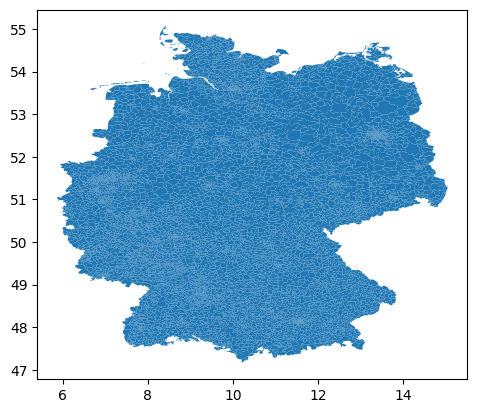

In [8]:
# Plot the GeoDataFrame for visualization
gdf.plot()

# Print the length of the list 'mongo_data_list'
print(len(mongo_data_list))


Connect to MongoDB Local, Integrate Data in Chunks

In [9]:
from pymongo import MongoClient
import json

class MongoDBConnector:
    def __init__(self, database_name, collection_name, host='localhost', port=27017):
        # Initialize MongoDB connection parameters
        self.client = MongoClient(host, port)
        self.db = self.client[database_name]
        self.collection = self.db[collection_name]

    def connect_to_local_mongodb(self):
        # Connect to local MongoDB and return the client and collection instances
        print("Connected to local MongoDB")
        return self.client, self.collection

    def insert_geojson_data(self, geojson_file_path, chunk_size=1000):
        try:
            # Read GeoJSON file
            with open(geojson_file_path, 'r') as file:
                geojson_data = json.load(file)

            # Extract features from GeoJSON
            features = geojson_data.get('features', [])

            # Insert data into MongoDB in chunks
            for i in range(0, len(features), chunk_size):
                chunk = features[i:i + chunk_size]
                self.collection.insert_many(chunk)
                print(f"Inserted {len(chunk)} features into local MongoDB collection '{self.collection.name}'.")

        except Exception as e:
            print(f"Error inserting data into MongoDB: {e}")

    def close_connection(self):
        try:
            # Close MongoDB connection
            self.client.close()
            print("Closed MongoDB connection.")
        except Exception as e:
            print(f"Error closing MongoDB connection: {e}")

# Example usage of the class
if __name__ == "__main__":
    # User input for the database and collection names
    database_name = "ZIP_Poly_DB_GeoJson_Test"
    collection_name = "ZIP_Poly_Collection_GeoJson_Test"

    # Create an instance of MongoDBConnector
    mongo_connector = MongoDBConnector(database_name, collection_name)

    # Connect to MongoDB
    mongo_client, mongo_collection = mongo_connector.connect_to_local_mongodb()

    # Example GeoJSON file path
    geojson_file_path = 'Germany_postal_codes.geojson'  # Update the file path accordingly

    # Insert GeoJSON data into MongoDB
    mongo_connector.insert_geojson_data(geojson_file_path, chunk_size=1000)

    # Close MongoDB connection when done
    mongo_connector.close_connection()


Connected to local MongoDB
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Collection_GeoJson_Test'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Collection_GeoJson_Test'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Collection_GeoJson_Test'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Collection_GeoJson_Test'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Collection_GeoJson_Test'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Collection_GeoJson_Test'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Collection_GeoJson_Test'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Collection_GeoJson_Test'.
Inserted 274 features into local MongoDB collection 'ZIP_Poly_Collection_GeoJson_Test'.
Closed MongoDB connection.


---

Poly Functions


Connect to MongoDB, get Polygon Shape & Data - Input: Postal Code - Output: Polygon Shape & Data

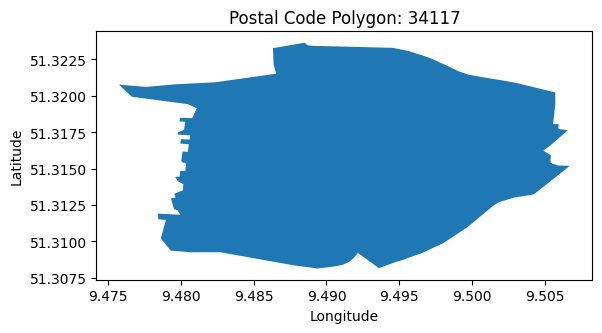

Selected Polygon Information:
POLYGON ((9.4757436 51.3207645, 9.4776032 51.3206073, 9.4796463 51.3207892, 9.4823482 51.320925, 9.4865459 51.3215156, 9.4863685 51.3221459, 9.4863246 51.3232692, 9.4885094 51.323645, 9.4886636 51.3235004, 9.4887893 51.3234516, 9.4891333 51.3234269, 9.491381 51.3233725, 9.4945481 51.3232914, 9.4956217 51.3230797, 9.4966232 51.3227593, 9.4971661 51.3225718, 9.4984949 51.321968, 9.499068 51.3216853, 9.4997424 51.3214482, 9.5009621 51.3212365, 9.5021754 51.3210394, 9.5030204 51.3208864, 9.5057135 51.3202296, 9.5057238 51.3194333, 9.5055623 51.3180545, 9.5059413 51.3180525, 9.5059333 51.3177153, 9.506594 51.3176393, 9.5054007 51.3166035, 9.5048986 51.3162318, 9.5054078 51.3159155, 9.5053889 51.3154057, 9.5056556 51.3152783, 9.505686 51.3153018, 9.5058858 51.3152088, 9.5067184 51.3151902, 9.5042477 51.3132263, 9.5028925 51.3130033, 9.5018798 51.312701, 9.5014944 51.3124757, 9.4996728 51.3109643, 9.4980295 51.3098796, 9.4964866 51.3091642, 9.4958408 51.3089457, 

In [10]:
import osmnx as ox
import geopandas as gpd
import json
from shapely.geometry import shape, Polygon, MultiPolygon
from pymongo import MongoClient
import matplotlib.pyplot as plt

# Set the default CRS to EPSG:25832
ox.settings.default_crs = "epsg:25832"

def connect_to_mongodb(database_name, collection_name):
    """
    Connects to MongoDB and returns the MongoDB client and collection.
    """
    client = MongoClient('localhost', 27017)
    db = client[database_name]
    collection = db[collection_name]
    return client, collection

def retrieve_data_from_mongodb(collection):
    """
    Retrieves GeoJSON data from MongoDB collection.
    """
    cursor = collection.find()
    geojson_data = {"type": "FeatureCollection", "features": []}

    for document in cursor:
        geojson_data["features"].append(document)

    return geojson_data

def coordinates_to_polygon(coordinates):
    """
    Converts coordinates to a Shapely Polygon or MultiPolygon.
    """
    # Check if coordinates are nested (indicating a polygon with holes)
    if isinstance(coordinates[0][0], list):
        # Create a MultiPolygon
        return MultiPolygon([Polygon(part) for part in coordinates])
    else:
        # Create a Polygon
        return Polygon(coordinates)

def plot_polygon(postal_code_polygons, postal_code):
    """
    Plots the polygon for a given postal code and returns the polygon.
    """
    polygon = postal_code_polygons.get(postal_code)
    if polygon:
        gdf = gpd.GeoDataFrame(geometry=[polygon])
        gdf.plot()
        plt.title(f"Postal Code Polygon: {postal_code}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()
        return polygon
    else:
        print(f"No polygon found for postal code: {postal_code}")
        return None

if __name__ == "__main__":
    # MongoDB configuration
    database_name = "ZIP_Poly_DB_GeoJson_Test"
    collection_name = "ZIP_Poly_Collection_GeoJson_Test"

    # Connect to MongoDB
    mongo_client, mongo_collection = connect_to_mongodb(database_name, collection_name)

    # Retrieve GeoJSON data from MongoDB
    geojson_data_from_mongo = retrieve_data_from_mongodb(mongo_collection)

    # Load GeoJSON data from MongoDB for comparison
    postal_code_polygons_mongo = {document.get('properties', {}).get('postal_code'): coordinates_to_polygon(document.get('geometry', {}).get('coordinates')[0]) for document in geojson_data_from_mongo['features']}

    # Input the postal code you want to plot
    input_postal_code = input("Enter a postal code: ")

    # Plot the polygon for the specified postal code and get the polygon
    selected_polygon = plot_polygon(postal_code_polygons_mongo, input_postal_code)

    # Output the polygon information
    if selected_polygon:
        print("Selected Polygon Information:")
        print(selected_polygon)
        print("Postal Code used:", input_postal_code)

    # Close MongoDB connection when done
    mongo_client.close()


Connect to MongoDB, use Coordinate and find nearest Postal Code - Input: Latitude, Longitude - Output: Postal Code, Polygon Shape & Data

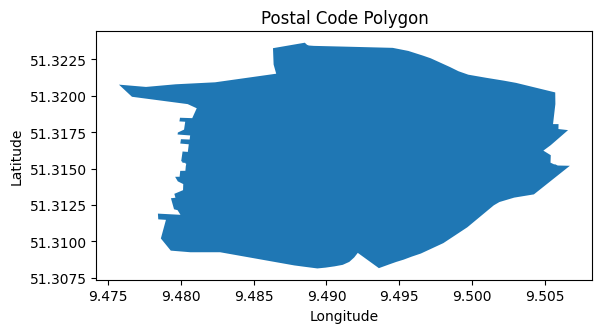

The postal code for the point (51.316669, 9.5) is: 34117
Selected Polygon Information:
POLYGON ((9.4757436 51.3207645, 9.4776032 51.3206073, 9.4796463 51.3207892, 9.4823482 51.320925, 9.4865459 51.3215156, 9.4863685 51.3221459, 9.4863246 51.3232692, 9.4885094 51.323645, 9.4886636 51.3235004, 9.4887893 51.3234516, 9.4891333 51.3234269, 9.491381 51.3233725, 9.4945481 51.3232914, 9.4956217 51.3230797, 9.4966232 51.3227593, 9.4971661 51.3225718, 9.4984949 51.321968, 9.499068 51.3216853, 9.4997424 51.3214482, 9.5009621 51.3212365, 9.5021754 51.3210394, 9.5030204 51.3208864, 9.5057135 51.3202296, 9.5057238 51.3194333, 9.5055623 51.3180545, 9.5059413 51.3180525, 9.5059333 51.3177153, 9.506594 51.3176393, 9.5054007 51.3166035, 9.5048986 51.3162318, 9.5054078 51.3159155, 9.5053889 51.3154057, 9.5056556 51.3152783, 9.505686 51.3153018, 9.5058858 51.3152088, 9.5067184 51.3151902, 9.5042477 51.3132263, 9.5028925 51.3130033, 9.5018798 51.312701, 9.5014944 51.3124757, 9.4996728 51.3109643, 9.4980295

In [11]:
import osmnx as ox
import geopandas as gpd
import json
from shapely.geometry import MultiPolygon, Polygon, Point
import matplotlib.pyplot as plt
from pymongo import MongoClient

# Set the default CRS to EPSG:25832
ox.settings.default_crs = "epsg:25832"

def connect_to_mongodb(database_name, collection_name):
    """
    Connects to MongoDB and returns the MongoDB client and collection.
    """
    client = MongoClient('localhost', 27017)
    db = client[database_name]
    collection = db[collection_name]
    return client, collection

def retrieve_data_from_mongodb(collection):
    """
    Retrieves GeoJSON data from MongoDB collection.
    """
    cursor = collection.find()
    geojson_data = {"type": "FeatureCollection", "features": []}

    for document in cursor:
        geojson_data["features"].append(document)

    return geojson_data

def coordinates_to_geometry(coordinates):
    """
    Converts coordinates to a Shapely Polygon or MultiPolygon.
    """
    # Check if coordinates are nested (indicating a polygon with holes)
    if isinstance(coordinates[0][0], list):
        # Create a MultiPolygon
        return MultiPolygon([Polygon(part) for part in coordinates])
    else:
        # Create a Polygon
        return Polygon(coordinates)

def insert_data_to_mongodb(data, collection):
    """
    Inserts GeoJSON data into MongoDB collection.
    """
    collection.insert_many(data['features'])
    print(f"Inserted {len(data['features'])} features into MongoDB collection '{collection.name}'.")

def plot_polygon(polygon):
    """
    Plots a Shapely Polygon.
    """
    gdf = gpd.GeoDataFrame(geometry=[polygon])
    gdf.plot()
    plt.title("Postal Code Polygon")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

def get_postal_code_for_point(point, postal_code_polygons):
    """
    Returns the postal code and polygon for a given Point and postal code polygons.
    """
    for postal_code, polygon in postal_code_polygons.items():
        if polygon.contains(point):
            return postal_code, polygon

    return None, None

if __name__ == "__main__":
    # MongoDB configuration
    database_name = "ZIP_Poly_DB_GeoJson_Test"
    collection_name = "ZIP_Poly_Collection_GeoJson_Test"

    # Connect to MongoDB
    mongo_client, mongo_collection = connect_to_mongodb(database_name, collection_name)

    # Retrieve GeoJSON data from MongoDB
    geojson_data_from_mongo = retrieve_data_from_mongodb(mongo_collection)

    # Load GeoJSON data from MongoDB for comparison
    postal_code_polygons_mongo = {document.get('properties', {}).get('postal_code'): coordinates_to_geometry(document.get('geometry', {}).get('coordinates')[0]) for document in geojson_data_from_mongo['features']}

    # Input latitude and longitude for the point
    latitude = float(51.316669)
    longitude = float(9.500000)

    # Create a Point object for the specified latitude and longitude
    point = Point(longitude, latitude)

    # Get the postal code and polygon for the specified point
    postal_code, selected_polygon = get_postal_code_for_point(point, postal_code_polygons_mongo)

    # Plot the polygon for the specified postal code
    if postal_code and selected_polygon:
        plot_polygon(selected_polygon)
        print(f"The postal code for the point ({latitude}, {longitude}) is: {postal_code}")
        # Access the selected polygon as needed
        print("Selected Polygon Information:")
        print(selected_polygon)
    else:
        print(f"No postal code found for the point ({latitude}, {longitude}).")

    # Close MongoDB connection when done
    mongo_client.close()
